In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'NQ'
start_date='20180301'
end_date='20191231'
periods=[5,10,20,40,80,160]
inds = {
    'bollir': run(sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': run(sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': run(sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
    'carver': run(sym, carver, adjustment=40, start_date=start_date, end_date=end_date, periods=periods),
    'roc': run(sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}

In [10]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
bollir,9.43193,6.14745
ema,10.0827,6.10586
breakout,9.45715,6.38373
carver,8.22556,5.43567
roc,9.05004,5.74842


In [11]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,bollir,ema,breakout,carver,roc
bollir,1.000000,0.802164,0.939957,0.933770,0.930399
ema,0.802164,1.000000,0.756367,0.760383,0.908040
breakout,0.939957,0.756367,1.000000,0.928394,0.887215
carver,0.933770,0.760383,0.928394,1.000000,0.902176
roc,0.930399,0.908040,0.887215,0.902176,1.000000


In [12]:
c.sum()

bollir      4.606290
ema         4.226955
breakout    4.511933
carver      4.524722
roc         4.627830
dtype: float64

In [13]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df

In [14]:
data=combine(inds, )

In [15]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.79052287036619, 5.616638630818714)

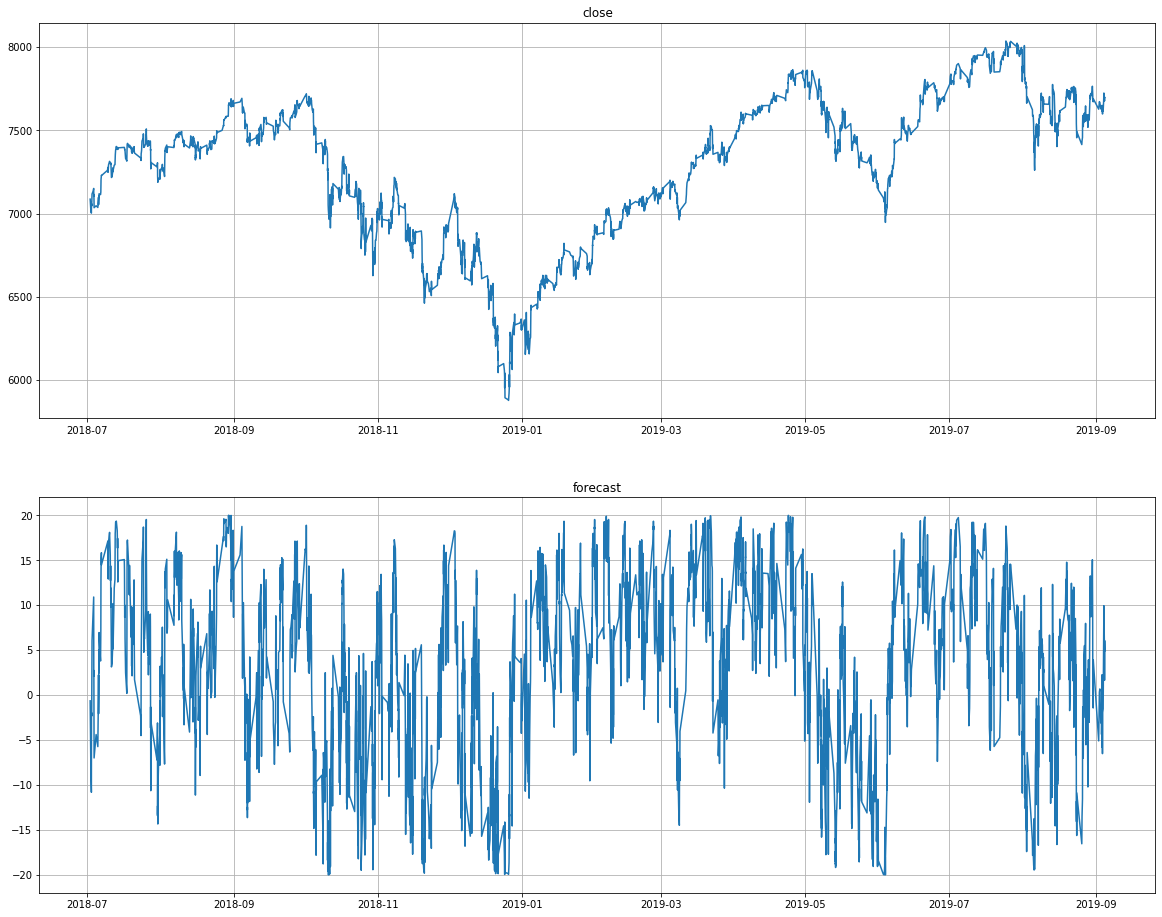

In [16]:
plot(data[['close', 'forecast']])

In [17]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.293404,0.124909,0.132507,0.0739554,0.0856376,0.0484947,-0.0528819,-0.010184,-0.0184235
Cumulative returns,0.370906,0.15526,0.164835,0.0914279,0.106003,0.0597859,-0.06445,-0.0124731,-0.0225434
Annual volatility,0.152359,0.155122,0.150272,0.152402,0.144407,0.117569,0.0744719,0.053532,0.0290463
Sharpe ratio,1.76526,0.836127,0.902953,0.544041,0.640993,0.461163,-0.692458,-0.164639,-0.625692
Calmar ratio,3.96978,1.72534,1.79906,0.719879,0.856951,0.569349,-0.525395,-0.232727,-0.430344
Stability,0.96689,0.916523,0.876259,0.673876,0.734657,0.581327,0.645457,0.41239,0.466199
Max drawdown,-0.0739094,-0.0723967,-0.0736534,-0.102733,-0.0999329,-0.0851757,-0.100652,-0.0437592,-0.042811
Omega ratio,1.34983,1.15248,1.16952,1.09958,1.11943,1.09553,0.830789,0.948227,0.757248
Sortino ratio,2.7663,1.26938,1.42059,0.827543,0.963909,0.747627,-1.00929,-0.270424,-0.881642
Skew,0.205105,0.208469,0.382692,0.270595,0.132079,0.886134,0.943949,1.83477,0.00563534


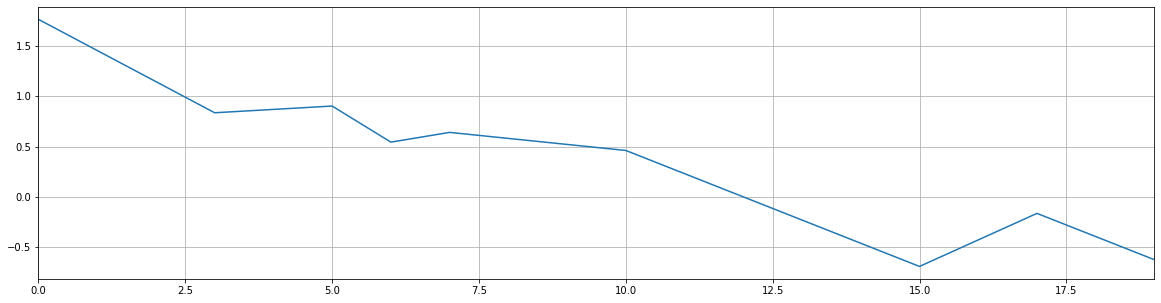

In [18]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [19]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.910352,0.828137,0.788178,0.775732,0.720559,0.481779,0.436782,0.197850
3,0.910352,1.000000,0.911408,0.865709,0.836376,0.742793,0.528487,0.467694,0.177293
5,0.828137,0.911408,1.000000,0.963633,0.920067,0.825209,0.562958,0.504727,0.210010
6,0.788178,0.865709,0.963633,1.000000,0.956672,0.856677,0.568391,0.498388,0.194314
7,0.775732,0.836376,0.920067,0.956672,1.000000,0.877677,0.564663,0.479329,0.176964
10,0.720559,0.742793,0.825209,0.856677,0.877677,1.000000,0.602999,0.543682,0.260652
15,0.481779,0.528487,0.562958,0.568391,0.564663,0.602999,1.000000,0.772618,0.488128
17,0.436782,0.467694,0.504727,0.498388,0.479329,0.543682,0.772618,1.000000,0.652948
19,0.197850,0.177293,0.210010,0.194314,0.176964,0.260652,0.488128,0.652948,1.000000


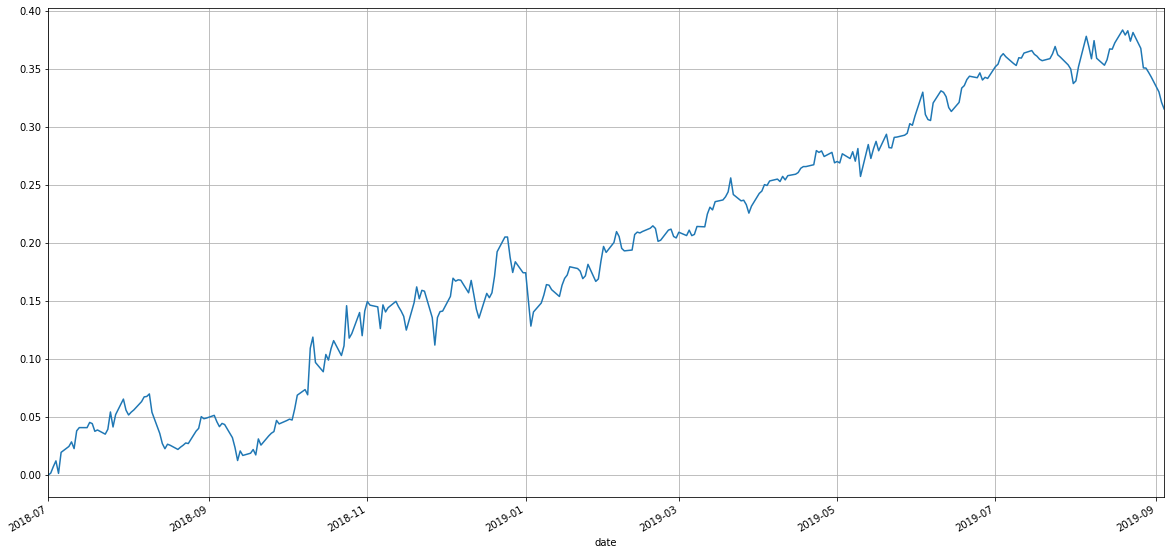

In [20]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

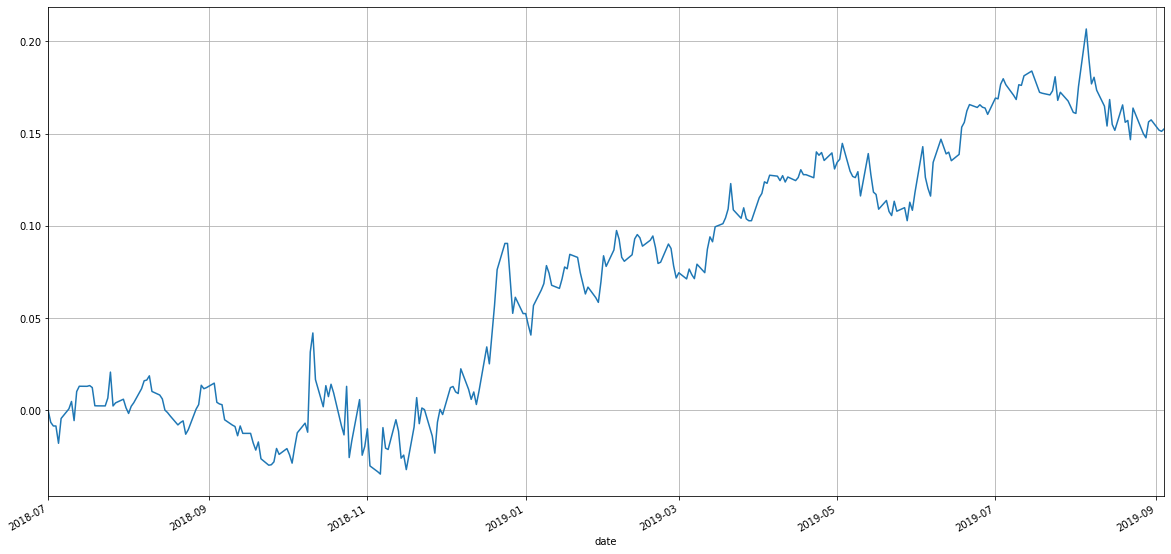

In [21]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

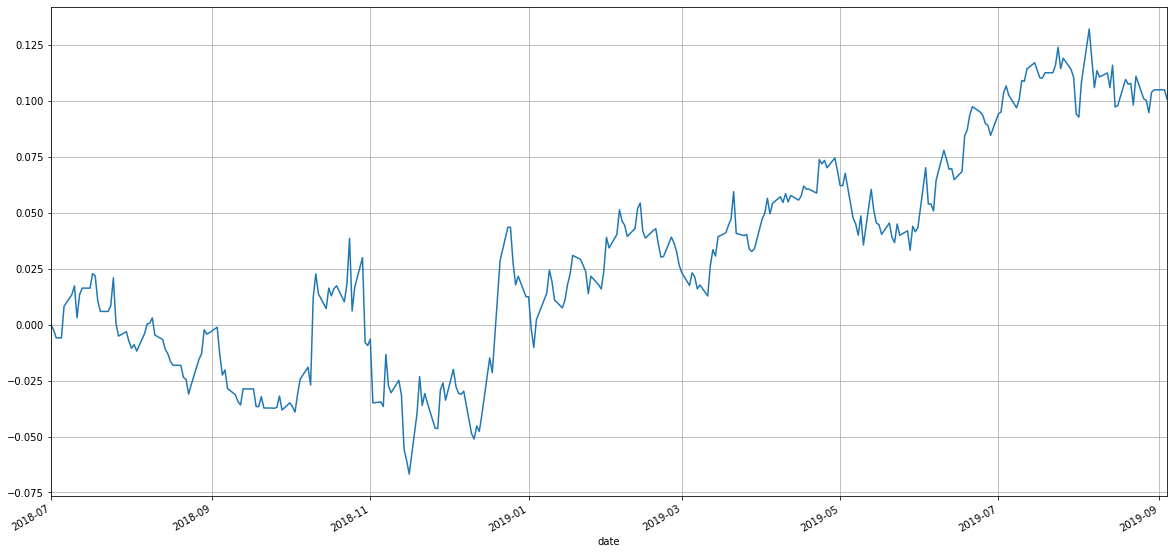

In [22]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

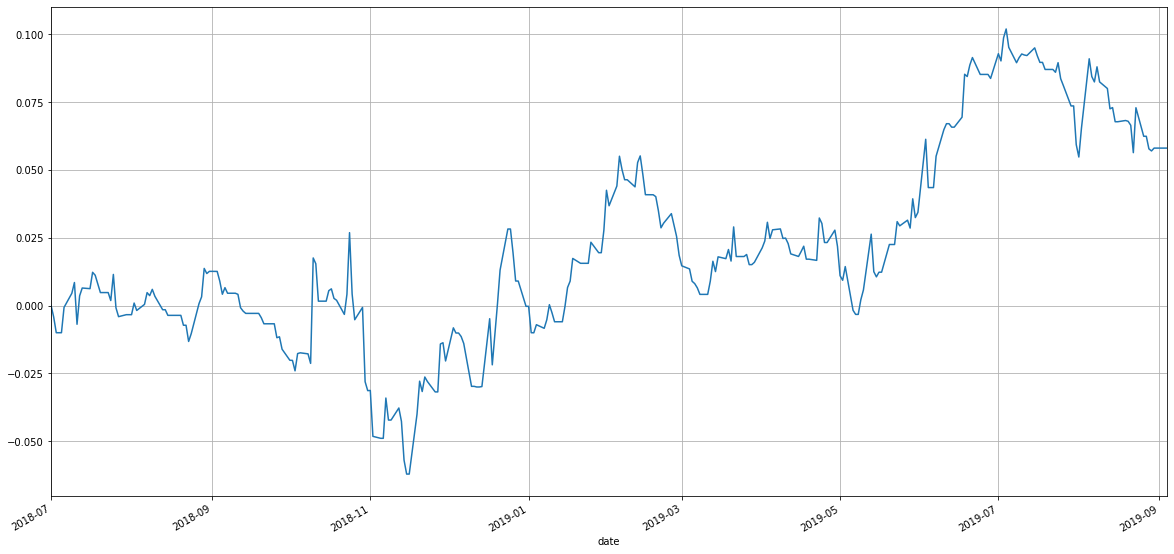

In [23]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);